# Bayesian Survival Analysis

**[Original tutorial](https://docs.pymc.io/notebooks/survival_analysis.html)**

Survival analysis studies the distribution of the time to an event.
This tutorial will use data on mastectomy results.

In [1]:
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from matplotlib import pyplot as plt
from pymc3.distributions.timeseries import GaussianRandomWalk
from theano import tensor as tt

gg.theme_set(gg.theme_minimal)
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 601
np.random.seed(RANDOM_SEED)

## Data

Each row in the data represents an observation from a woman diagnosed with breast cancer that underwent a mastectomy.
The column `time` represents the months post-surgery that the woman was observed.
The column `event` indicates whether or not the woman died during the observation period.
The column `metastized` indicates whether the cancer had metastized prior to surgery.

In [7]:
df = pd.read_csv(pm.get_data("mastectomy.csv"))
df["event"] = df.event.astype(np.int64)
df["metastized"] = (df.metastized == "yes").astype(np.int64)
n_patients = df.shape[0]
patients = np.arange(n_patients)

df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


In [8]:
n_patients

44

## A "crash course" on survival analysis

If the random variable $T$ is the time to the even we are studying, then survival anylsis is concerned with the survival function

$$
S(t) = P(T > t) = 1 - F(t)
$$

where $F$ is the CDF of $T$.
It is convenient the express the survival function in terms of the **hazard rate** $\lambda(t)$: the instantaneous propbability that the event occurs at time $t$ given it has yet to occur.
That is,

$$
\begin{align}
\lambda(t) &= \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t | T > t)}{\Delta t} \\
&= \lim_{\Delta t \to 0} \frac{P(t < T < t + \Delta t)}{\Delta t \cdot P(T > t)} \\
&= \frac{1}{S(t)} \cdot \lim_{\Delta t \to 0} \frac{S(t + \Delta t) - S(t)}{\Delta t} = - \frac{S'(t)}{S(t)} \\
\end{align}
$$

Solving this differential equation for the survival function demonstrates

$$
S(t) = \exp \lgroup - \int_{0}^{s} \lambda(s) ds \rgroup
$$

Which inturn shows that the cumulative hazard function

$$
\Lambda(t) = \int_0^t \lambda(s) ds
$$

is an important quantity in survival analysis which we can concisely write as

$$
S(t) = \exp(- Lambda(t))
$$

An important part of survival analysis is **censoring** because we will not observe the death of every subject.
For our data, the column `event` is 1 if the subject's death ws observed and a 0 is the death was not observed (censored).
The time for a censored data point is *not* the subject's survival time, but, instead, we assume the subject's true survival time exceeds the time point.

In [9]:
df.head()

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0


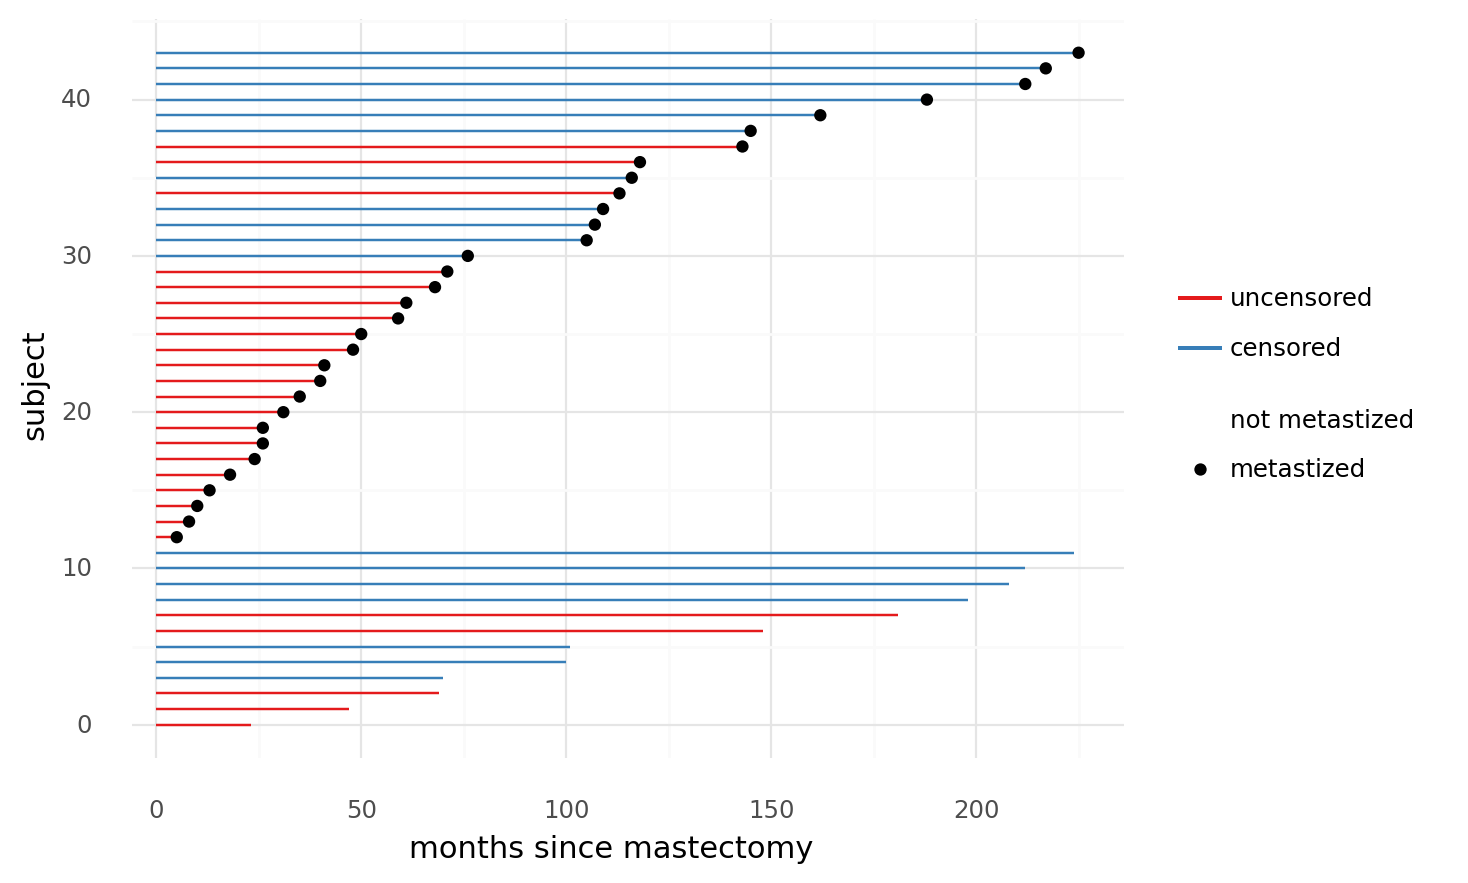

<ggplot: (353127903)>

In [19]:
plot_data = df.copy().reset_index(drop=False).rename(columns={"index": "subject_id"})

(
    gg.ggplot(plot_data, gg.aes(x="subject_id", y="time"))
    + gg.geom_linerange(gg.aes(ymax="time", color="factor(1-event)"), ymin=0)
    + gg.geom_point(gg.aes(alpha="factor(metastized)"))
    + gg.scale_color_brewer(
        type="qual", palette="Set1", labels=("uncensored", "censored")
    )
    + gg.scale_alpha_manual(values=(0, 1), labels=("not metastized", "metastized"))
    + gg.coord_flip()
    + gg.theme(legend_title=gg.element_blank())
    + gg.labs(x="subject", y="months since mastectomy")
)

## Bayesian proportional hazards model

Since our goal is to understand the impact of metastization on survival time, a risk regression model is appropriate.
The most commonly used risk regression model is the Cox's proportional hazards model.
In this model, with covariates $\textbf{x}$ and regression coefficients $\beta$, the hazard rate is modeled as

$$
\lambda(t) = \lambda_0 (t) \exp(\textbf{x} \beta)
$$

Here, $\lambda_0 (t)$ is the baseline hazard which is independent of the covariates $\textbf{x}$.

We need to specify priors for $\beta$ and $\lambda_0 (t)$.
For $\beta$, we can use a normal distribution $N(\mu_\beta, \sigma^2_\beta)$ and model set uniform priors on those parameters.

Since $\lambda_0 (t)$ is a piecewise constant function, its prior will be a semiparametric prior that requires us to partition the time range into intervals with endpoints $0 \leq s_1 \lt s_2 \lt \dots \lt s_N$.
With this partition, $\lambda_0 (t) = \lambda_j$ if $s_j \leq t \lt s_{j+1}$.
With $\lambda_0 (t)$ constrained to have this form, we just need to provide priors for the N-1 values $\lambda_j$.
We can use independent vague priors $\lambda_j \sim \text{Gamma}(10^{-2}, 10^{-2})$ and each interval will be 3 months long.